In [1]:
!chmod 600 ~/.kaggle/kaggle.json
!pip install kaggle

In [2]:
!pip install kagglehub

In [3]:
import kagglehub

# Download the dataset (latest version)
path = kagglehub.dataset_download("muhammadehsan02/formula-1-world-championship-history-1950-2024")

print("Path to dataset files:", path)

Path to dataset files: /Users/alanurgorkem/.cache/kagglehub/datasets/muhammadehsan02/formula-1-world-championship-history-1950-2024/versions/1


In [4]:
import os

project_folder = "/Users/alanurgorkem/Documents/F1_Project/f1_data"
os.makedirs(project_folder, exist_ok=True)

In [5]:
#THE PREVIOUS STEPS ARE PERFORMED TO CONNECT TO KAGGLEAPI to download the files 

import shutil

data_path = "/Users/alanurgorkem/.cache/kagglehub/datasets/muhammadehsan02/formula-1-world-championship-history-1950-2024/versions/1"

files_to_copy = [
    "Race_Results.csv",
    "Driver_Details.csv",
    "Team_Details.csv",
    "Race_Schedule.csv",
    "Qualifying_Results.csv",
    "Driver_Rankings.csv",
    "Constructor_Rankings.csv"
]

for file_name in files_to_copy:
    shutil.copy(os.path.join(data_path, file_name), project_folder)

print("Selected CSVs copied to project folder!")

Selected CSVs copied to project folder!


In [6]:
#Step 1 - importing the CSV files by using KaggleAPI - we only use the ones we need for modelling

import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


race_results = pd.read_csv(os.path.join(project_folder, "Race_Results.csv"))
drivers = pd.read_csv(os.path.join(project_folder, "Driver_Details.csv"))
teams = pd.read_csv(os.path.join(project_folder, "Team_Details.csv"))
qualifying = pd.read_csv(os.path.join(project_folder, "Qualifying_Results.csv"))
races = pd.read_csv(os.path.join(project_folder, "Race_Schedule.csv"))
driver_ranking = pd.read_csv(os.path.join(project_folder, "Driver_Rankings.csv"))
constructor_ranking= pd.read_csv(os.path.join(project_folder, "Constructor_Rankings.csv"))


# Quick check
for name, df in [('Race Results', race_results), ('Drivers', drivers), ('Teams', teams), ('Qualifying', qualifying), ('Races', races),('Driver_Ranking', driver_ranking),('Constructor_Ranking', constructor_ranking)]:
    print(f"\n{name} → shape: {df.shape}")
    print(df.head(2))



Race Results → shape: (26519, 18)
   resultId  raceId  driverId  constructorId number  grid position  \
0         1      18         1              1     22     1        1   
1         2      18         2              2      3     5        2   

  positionText  positionOrder  points  laps         time milliseconds  \
0            1              1    10.0    58  1:34:50.616      5690616   
1            2              2     8.0    58       +5.478      5696094   

  fastestLap rank fastestLapTime fastestLapSpeed  statusId  
0         39    2       1:27.452         218.300         1  
1         41    3       1:27.739         217.586         1  

Drivers → shape: (859, 9)
   driverId driverRef number code forename   surname         dob nationality  \
0         1  hamilton     44  HAM    Lewis  Hamilton  1985-01-07     British   
1         2  heidfeld     \N  HEI     Nick  Heidfeld  1977-05-10      German   

                                           url  
0  http://en.wikipedia.org/wiki/Le

In [7]:
#1.1 - Replace missing placeholders
for df in [race_results, drivers, teams, qualifying, races,driver_ranking, constructor_ranking]:
    df.replace(['\\N', '--', ' '], np.nan, inplace=True)

In [8]:
for name, df in [('Race Results', race_results), ('Drivers', drivers), ('Teams', teams), ('Qualifying', qualifying), ('Races', races),('Driver_Ranking', driver_ranking), ('Constructor_Ranking', constructor_ranking)]:
    print(f"\n{name} → shape: {df.shape}")
    print(df.head(2))


Race Results → shape: (26519, 18)
   resultId  raceId  driverId  constructorId number  grid position  \
0         1      18         1              1     22     1        1   
1         2      18         2              2      3     5        2   

  positionText  positionOrder  points  laps         time milliseconds  \
0            1              1    10.0    58  1:34:50.616      5690616   
1            2              2     8.0    58       +5.478      5696094   

  fastestLap rank fastestLapTime fastestLapSpeed  statusId  
0         39    2       1:27.452         218.300         1  
1         41    3       1:27.739         217.586         1  

Drivers → shape: (859, 9)
   driverId driverRef number code forename   surname         dob nationality  \
0         1  hamilton     44  HAM    Lewis  Hamilton  1985-01-07     British   
1         2  heidfeld    NaN  HEI     Nick  Heidfeld  1977-05-10      German   

                                           url  
0  http://en.wikipedia.org/wiki/Le

In [9]:
#Step 2 - Cleaning the datasets

#2.1 - races dataset 

# Convert all relevant date columns
date_cols = ['date', 'fp1_date', 'fp2_date', 'fp3_date', 'quali_date', 'sprint_date']
for col in date_cols:
    if col in races.columns:
        races[col] = pd.to_datetime(races[col], errors='coerce')

# Combine main date and time (if both exist)
if 'date' in races.columns and 'time' in races.columns:
    races['race_datetime'] = pd.to_datetime(
        races['date'].astype(str) + ' ' + races['time'].astype(str),
        errors='coerce'
    )

# Keep only the useful columns for merging
races_clean = races[['raceId', 'year', 'name', 'race_datetime']]

#check for duplicates
race_duplicates = races_clean.duplicated(subset=['raceId'])
print("Duplicate raceId count:", race_duplicates.sum())

# Check missing values
missing_count = races_clean['race_datetime'].isnull().sum()
print(f"Missing values in race_datetime: {missing_count}")

races_clean.head()


Duplicate raceId count: 0
Missing values in race_datetime: 731


,raceId,year,name,race_datetime
0,1,2009,Australian Grand Prix,2009-03-29 06:00:00
1,2,2009,Malaysian Grand Prix,2009-04-05 09:00:00
2,3,2009,Chinese Grand Prix,2009-04-19 07:00:00
3,4,2009,Bahrain Grand Prix,2009-04-26 12:00:00
4,5,2009,Spanish Grand Prix,2009-05-10 12:00:00


In [10]:
#2.2 - #2.2 - drivers dataset 

drivers['dob'] = pd.to_datetime(drivers['dob'], errors='coerce')
drivers_clean = drivers[['driverId', 'forename', 'surname', 'dob', 'nationality']]

#check for duplicates: 0  duplicates we are fine

duplicate_drivers = drivers_clean.duplicated(subset=['driverId']).sum()
print("Duplicate driverId count:", duplicate_drivers)

#check for missing values: 0 missing values. doing great
print("Missing values per column:")
print(drivers_clean.isnull().sum())

#drivers have no year info we will have a look at that seperately

drivers_clean.head()

Duplicate driverId count: 0
Missing values per column:
driverId       0
forename       0
surname        0
dob            0
nationality    0
dtype: int64


,driverId,forename,surname,dob,nationality
0,1,Lewis,Hamilton,1985-01-07,British
1,2,Nick,Heidfeld,1977-05-10,German
2,3,Nico,Rosberg,1985-06-27,German
3,4,Fernando,Alonso,1981-07-29,Spanish
4,5,Heikki,Kovalainen,1981-10-19,Finnish


In [11]:
# 2.3 - teams 

teams_clean = teams[['constructorId', 'name', 'nationality']].copy()  # 👈 make a full copy
teams_clean.rename(columns={'name': 'team_name', 'nationality': 'team_nationality'}, inplace=True)

#check for duplicates: 0 duplicates
duplicate_teams = teams_clean.duplicated(subset=['constructorId']).sum()
print("Duplicate constructorId count:", duplicate_teams)

#check for missing values: 0 missing values
print("Missing values per column:")
print(teams_clean.isnull().sum())

teams_clean.head(5)

#teams have no year info we will have a look at that seperately

Duplicate constructorId count: 0
Missing values per column:
constructorId       0
team_name           0
team_nationality    0
dtype: int64


,constructorId,team_name,team_nationality
0,1,McLaren,British
1,2,BMW Sauber,German
2,3,Williams,British
3,4,Renault,French
4,5,Toro Rosso,Italian


In [12]:
#2.4- Constructor ranking clean 

constructor_ranking = constructor_ranking.rename(columns={
    'points': 'constructor_ranking_points',
    'position': 'constructor_ranking_position',
    'wins': 'constructor_ranking_wins'
})



#check for duplicates:0
duplicate_cons = constructor_ranking.duplicated(subset=['raceId', 'constructorId']).sum()
print("Duplicate (raceId, constructorId) pairs:", duplicate_cons)

constructor_ranking.head(5)

Duplicate (raceId, constructorId) pairs: 0


,constructorStandingsId,raceId,constructorId,constructor_ranking_points,constructor_ranking_position,positionText,constructor_ranking_wins
0,1,18,1,14.0,1,1,1
1,2,18,2,8.0,3,3,0
2,3,18,3,9.0,2,2,0
3,4,18,4,5.0,4,4,0
4,5,18,5,2.0,5,5,0


In [13]:
#2.5 - qualifying dataset

qualifying_clean = qualifying[['raceId', 'driverId', 'constructorId', 'position']]

#rename the column 
qualifying_clean = qualifying[['raceId', 'driverId', 'constructorId', 'position']].copy()
qualifying_clean = qualifying_clean.rename(columns={'position': 'qualifying_position'})


#check for duplicates:0
duplicate_qual = qualifying_clean.duplicated(subset=['raceId', 'driverId']).sum()
print("Duplicate (raceId, driverId) pairs:", duplicate_qual)

#check for missing values 
print("Missing values per column:")
print(qualifying_clean.isnull().sum())

qualifying_clean.head(5)

Duplicate (raceId, driverId) pairs: 0
Missing values per column:
raceId                 0
driverId               0
constructorId          0
qualifying_position    0
dtype: int64


,raceId,driverId,constructorId,qualifying_position
0,18,1,1,1
1,18,9,2,2
2,18,5,1,3
3,18,13,6,4
4,18,2,2,5


In [14]:
##2.6 - race results dataset

race_results_clean = race_results[['resultId', 'raceId', 'driverId', 'constructorId', 'grid', 'positionOrder', 'points', 'statusId']]

print(race_results_clean.isnull().sum())

# Check duplicates in the full race_results_clean
duplicate_count = race_results_clean.duplicated(subset=['raceId', 'driverId']).sum()
print("Duplicate (raceId, driverId) pairs in race_results_clean:", duplicate_count)

#show duplicates - we see that they are not true duplicates 
duplicates = race_results_clean[race_results_clean.duplicated(subset=['raceId', 'driverId'], keep=False)]
print(duplicates.sort_values(['raceId', 'driverId']).head(10))

#there are 91 duplicates basically it looks like 1 driver raced on 1 race and there are different constructorIDs. They are actual duplicates we need to clean
# Prioritize actual starters (grid > 0) and better finishers (lower positionOrder)
race_results_clean = (
    race_results_clean
    .sort_values(by=['grid', 'positionOrder'], ascending=[False, True])
    .drop_duplicates(subset=['raceId', 'driverId'], keep='first')
)

print("Remaining duplicates:", race_results_clean.duplicated(subset=['raceId', 'driverId']).sum())

race_results_clean.head()

race_results_clean.shape

resultId         0
raceId           0
driverId         0
constructorId    0
grid             0
positionOrder    0
points           0
statusId         0
dtype: int64
Duplicate (raceId, driverId) pairs in race_results_clean: 91
       resultId  raceId  driverId  constructorId  grid  positionOrder  points  \
13188     13189     540       229             54     0             26     0.0   
13191     13192     540       229             57     0             29     0.0   
17362     17363     717       373            172     1              7     0.0   
24298     24304     717       373            172     1             12     0.0   
17740     17741     733       465            172     0             22     0.0   
17743     17744     733       465             97     0             25     0.0   
17961     17962     742       475            102    20             19     0.0   
17963     17964     742       475            172     5             21     0.0   
18062     18063     745       418            

(26428, 8)

In [15]:
#2.7 - driver rankings data cleaning

duplicates = driver_ranking.duplicated(subset=['raceId', 'driverId'], keep=False)
driver_ranking[duplicates].sort_values(['driverId', 'raceId']).head(10)

driver_ranking.rename(columns={
    'driverStandingsId': 'driver_standings_id',
    'raceId': 'race_id',
    'driverId': 'driver_id',
    'positionText': 'position_text'
}, inplace=True)

# correcting types
driver_ranking['race_id'] = driver_ranking['race_id'].astype(int)
driver_ranking['driver_id'] = driver_ranking['driver_id'].astype(int)

driver_ranking['points'] = pd.to_numeric(driver_ranking['points'], errors='coerce')
driver_ranking['position'] = pd.to_numeric(driver_ranking['position'], errors='coerce')
driver_ranking['wins'] = pd.to_numeric(driver_ranking['wins'], errors='coerce')


# null values control 
print("\nMissing values:\n", driver_ranking.isnull().sum())

duplicates = driver_ranking.duplicated(subset=['race_id', 'driver_id']).sum()
print(f"\nDuplicate records found: {duplicates}")

# Last Control
print("\nCleaned Driver Ranking preview:")
print(driver_ranking.head())




Missing values:
 driver_standings_id    0
race_id                0
driver_id              0
points                 0
position               0
position_text          0
wins                   0
dtype: int64

Duplicate records found: 0

Cleaned Driver Ranking preview:
   driver_standings_id  race_id  driver_id  points  position position_text  \
0                    1       18          1    10.0         1             1   
1                    2       18          2     8.0         2             2   
2                    3       18          3     6.0         3             3   
3                    4       18          4     5.0         4             4   
4                    5       18          5     4.0         5             5   

   wins  
0     1  
1     0  
2     0  
3     0  
4     0  


In [16]:
#Step 3 - Merging all the CSVs in 1 master file 

#3.1 - Merge race_results with races_clean based on raceId
master_df = race_results_clean.merge(
    races_clean[['raceId', 'year', 'name', 'race_datetime']],
    on='raceId',
    how='left'
)

# Check the result
print(master_df.shape)
master_df.head()


(26428, 11)


,resultId,raceId,driverId,constructorId,grid,positionOrder,points,statusId,year,name,race_datetime
0,19577,814,711,144,34,22,0.0,31,1953,German Grand Prix,NaT
1,19104,794,512,114,33,4,3.0,1,1955,Indianapolis 500,NaT
2,18552,768,560,113,33,10,0.0,1,1958,Indianapolis 500,NaT
3,18770,778,516,113,33,13,0.0,13,1957,Indianapolis 500,NaT
4,18328,757,535,113,33,16,0.0,1,1959,Indianapolis 500,NaT


In [17]:
#3.1 - sanity checks 

#check for duplicates after the merge 

# Each driver should appear once per race
duplicates = master_df.duplicated(subset=['raceId', 'driverId'], keep=False)
print("Number of duplicate (raceId, driverId) rows:", duplicates.sum())

# If you want to see some duplicate rows (should be 0)
if duplicates.sum() > 0:
    print(master_df[duplicates].sort_values(['raceId', 'driverId']).head(10))

duplicate_rows = race_results_clean[race_results_clean.duplicated(subset=['raceId', 'driverId'], keep=False)]
print("Number of duplicates in race_results_clean:", duplicate_rows.shape[0])
print(duplicate_rows.sort_values(['raceId', 'driverId']).head(10))

Number of duplicate (raceId, driverId) rows: 0
Number of duplicates in race_results_clean: 0
Empty DataFrame
Columns: [resultId, raceId, driverId, constructorId, grid, positionOrder, points, statusId]
Index: []


In [18]:
print("Before merge:", race_results_clean.shape[0])
print("After merge:", master_df.shape[0])

Before merge: 26428
After merge: 26428


In [19]:
#3.2  - merging teams 

master_df = master_df.merge(
    teams_clean,
    on='constructorId',
    how='left',
    validate='many_to_one'  # ensures no duplicate explosion
)

#sanity check after merge 

print("Rows before merge:", 26428)
print("Rows after merge:", master_df.shape[0])

dup_check = master_df.duplicated(subset=['raceId', 'driverId']).sum()
print("Duplicate (raceId, driverId) after merge:", dup_check)

master_df = master_df.drop(
    columns=[col for col in master_df.columns if '_x' in col or '_y' in col],
    errors='ignore'
)

Rows before merge: 26428
Rows after merge: 26428
Duplicate (raceId, driverId) after merge: 0


In [20]:
master_df.head()

,resultId,raceId,driverId,constructorId,grid,positionOrder,points,statusId,year,name,race_datetime,team_name,team_nationality
0,19577,814,711,144,34,22,0.0,31,1953,German Grand Prix,NaT,Veritas,German
1,19104,794,512,114,33,4,3.0,1,1955,Indianapolis 500,NaT,Kuzma,American
2,18552,768,560,113,33,10,0.0,1,1958,Indianapolis 500,NaT,Kurtis Kraft,American
3,18770,778,516,113,33,13,0.0,13,1957,Indianapolis 500,NaT,Kurtis Kraft,American
4,18328,757,535,113,33,16,0.0,1,1959,Indianapolis 500,NaT,Kurtis Kraft,American


In [21]:
#3.2 - sanity checks 

#sanity check after merge 

print("Rows before merge:", 26428)
print("Rows after merge:", master_df.shape[0])

dup_check = master_df.duplicated(subset=['raceId', 'driverId']).sum()
print("Duplicate (raceId, driverId) after merge:", dup_check)

Rows before merge: 26428
Rows after merge: 26428
Duplicate (raceId, driverId) after merge: 0


In [22]:
#3.3 - merging driver details into master_df

master_df = master_df.merge(
    drivers_clean,
    on='driverId',
    how='left',
    validate='many_to_one'   # each driverId should map to exactly one driver
)

print(master_df.shape)
master_df[['driverId', 'forename', 'surname', 'dob', 'nationality']].head()

(26428, 17)


,driverId,forename,surname,dob,nationality
0,711,Oswald,Karch,1917-03-06,German
1,512,Johnny,Thomson,1922-04-09,American
2,560,Bill,Cheesbourg,1927-06-12,American
3,516,Bob,Christie,1924-04-04,American
4,535,Jim,McWithey,1927-07-04,American


In [23]:
#renaming the columns of the drivers to avoid any confusion 

master_df = master_df.rename(columns={
    'nationality': 'driver_nationality',
    'dob': 'driver_dob',
    'forename': 'driver_forename',
    'surname': 'driver_surname'
})

In [24]:
master_df.head()

,resultId,raceId,driverId,constructorId,grid,positionOrder,points,statusId,year,name,race_datetime,team_name,team_nationality,driver_forename,driver_surname,driver_dob,driver_nationality
0,19577,814,711,144,34,22,0.0,31,1953,German Grand Prix,NaT,Veritas,German,Oswald,Karch,1917-03-06,German
1,19104,794,512,114,33,4,3.0,1,1955,Indianapolis 500,NaT,Kuzma,American,Johnny,Thomson,1922-04-09,American
2,18552,768,560,113,33,10,0.0,1,1958,Indianapolis 500,NaT,Kurtis Kraft,American,Bill,Cheesbourg,1927-06-12,American
3,18770,778,516,113,33,13,0.0,13,1957,Indianapolis 500,NaT,Kurtis Kraft,American,Bob,Christie,1924-04-04,American
4,18328,757,535,113,33,16,0.0,1,1959,Indianapolis 500,NaT,Kurtis Kraft,American,Jim,McWithey,1927-07-04,American


In [25]:
#sanity checks before merging with a new CSV 

# Check for duplicate (raceId, driverId) pairs — should be 0 ideally
duplicates = master_df.duplicated(subset=['raceId', 'driverId'], keep=False)
print("Number of duplicate (raceId, driverId) rows:", duplicates.sum())

# Show some if any remain
if duplicates.sum() > 0:
    display(master_df[duplicates].sort_values(['raceId', 'driverId']).head(10))

# Check for missing key values
print("\nMissing values:")
print(master_df[['raceId', 'driverId', 'constructorId']].isnull().sum())

# Check for uniqueness of drivers per race
unique_pairs = master_df.groupby(['raceId'])['driverId'].nunique()
print("\nAverage number of drivers per race:", unique_pairs.mean())

Number of duplicate (raceId, driverId) rows: 0

Missing values:
raceId           0
driverId         0
constructorId    0
dtype: int64

Average number of drivers per race: 23.744833782569632


In [26]:
#3.3 - sanity checks 

#sanity check for the drivers 

# Group by raceId and driverId — count how many unique constructors each driver had per race
team_check = (
    master_df.groupby(['raceId', 'driverId'])['constructorId']
    .nunique()
    .reset_index(name='unique_team_count')
)

# Find any cases where a driver appears under more than one team in the same race
multi_team_drivers = team_check[team_check['unique_team_count'] > 1]

print("Number of drivers with multiple teams in the same race:", len(multi_team_drivers))

# Display a few problematic rows if they exist
if len(multi_team_drivers) > 0:
    display(
        master_df[
            master_df.set_index(['raceId', 'driverId']).index.isin(
                multi_team_drivers.set_index(['raceId', 'driverId']).index
            )
        ].sort_values(['raceId', 'driverId'])
    )


Number of drivers with multiple teams in the same race: 0


In [27]:
#3.4 - merging driver rankings 

# Ensure driver_ranking columns are properly renamed ---
driver_ranking_clean = driver_ranking.rename(columns={
    'race_id': 'raceId',
    'driver_id': 'driverId',
    'points': 'driver_ranking_points',
    'position': 'driver_ranking_position',
    'wins': 'driver_ranking_wins'
})

In [28]:
#Merge driver_ranking_clean into master_df
master_df = master_df.merge(
    driver_ranking_clean[['raceId', 'driverId', 'driver_ranking_points', 'driver_ranking_position', 'driver_ranking_wins']],
    on=['raceId', 'driverId'],
    how='left',
    validate='many_to_one'  # Each driver should have only one row per race
)

# Sanity checks ---
print("After merging driver rankings:")
print("Master DF shape:", master_df.shape)

# Check duplicates: each driver should appear only once per race
duplicates = master_df.duplicated(subset=['raceId', 'driverId'], keep=False)
print("Number of duplicate (raceId, driverId) rows:", duplicates.sum())

# Check missing values in ranking columns
print("\nMissing values in ranking columns:")
print(master_df[['driver_ranking_points', 'driver_ranking_position', 'driver_ranking_wins']].isnull().sum())

# Peek at the head
master_df.head(5)

After merging driver rankings:
Master DF shape: (26428, 20)
Number of duplicate (raceId, driverId) rows: 0

Missing values in ranking columns:
driver_ranking_points      469
driver_ranking_position    469
driver_ranking_wins        469
dtype: int64


,resultId,raceId,driverId,constructorId,grid,positionOrder,points,statusId,year,name,race_datetime,team_name,team_nationality,driver_forename,driver_surname,driver_dob,driver_nationality,driver_ranking_points,driver_ranking_position,driver_ranking_wins
0,19577,814,711,144,34,22,0.0,31,1953,German Grand Prix,NaT,Veritas,German,Oswald,Karch,1917-03-06,German,0.0,84.0,0.0
1,19104,794,512,114,33,4,3.0,1,1955,Indianapolis 500,NaT,Kuzma,American,Johnny,Thomson,1922-04-09,American,3.0,9.0,0.0
2,18552,768,560,113,33,10,0.0,1,1958,Indianapolis 500,NaT,Kurtis Kraft,American,Bill,Cheesbourg,1927-06-12,American,0.0,25.0,0.0
3,18770,778,516,113,33,13,0.0,13,1957,Indianapolis 500,NaT,Kurtis Kraft,American,Bob,Christie,1924-04-04,American,0.0,31.0,0.0
4,18328,757,535,113,33,16,0.0,1,1959,Indianapolis 500,NaT,Kurtis Kraft,American,Jim,McWithey,1927-07-04,American,0.0,22.0,0.0


In [29]:
#3.5 - qualifying results 

# Merge qualifying positions including constructorId
master_df = master_df.merge(
    qualifying_clean[['raceId', 'driverId', 'constructorId', 'qualifying_position']],
    on=['raceId', 'driverId', 'constructorId'],
    how='left'
)

# Check the result
print("Master DF shape after merging qualifying:", master_df.shape)

# Check for duplicates
duplicates = master_df.duplicated(subset=['raceId', 'driverId', 'constructorId'], keep=False)
print("Number of duplicate (raceId, driverId, constructorId) rows:", duplicates.sum())

# Show a sample if there are duplicates
if duplicates.sum() > 0:
    print(master_df[duplicates].sort_values(['raceId', 'driverId']).head(10))

# Check for missing qualifying positions
missing_qual = master_df['qualifying_position'].isnull().sum()
print("Missing qualifying positions:", missing_qual)

master_df.head()

Master DF shape after merging qualifying: (26428, 21)
Number of duplicate (raceId, driverId, constructorId) rows: 0
Missing qualifying positions: 16184


,resultId,raceId,driverId,constructorId,grid,positionOrder,points,statusId,year,name,...,team_name,team_nationality,driver_forename,driver_surname,driver_dob,driver_nationality,driver_ranking_points,driver_ranking_position,driver_ranking_wins,qualifying_position
0,19577,814,711,144,34,22,0.0,31,1953,German Grand Prix,...,Veritas,German,Oswald,Karch,1917-03-06,German,0.0,84.0,0.0,NaN
1,19104,794,512,114,33,4,3.0,1,1955,Indianapolis 500,...,Kuzma,American,Johnny,Thomson,1922-04-09,American,3.0,9.0,0.0,NaN
2,18552,768,560,113,33,10,0.0,1,1958,Indianapolis 500,...,Kurtis Kraft,American,Bill,Cheesbourg,1927-06-12,American,0.0,25.0,0.0,NaN
3,18770,778,516,113,33,13,0.0,13,1957,Indianapolis 500,...,Kurtis Kraft,American,Bob,Christie,1924-04-04,American,0.0,31.0,0.0,NaN
4,18328,757,535,113,33,16,0.0,1,1959,Indianapolis 500,...,Kurtis Kraft,American,Jim,McWithey,1927-07-04,American,0.0,22.0,0.0,NaN


In [30]:
#3.6 -  Merge constructor ranking 

master_df = master_df.merge(
    constructor_ranking[['raceId', 'constructorId', 'constructor_ranking_points', 
                        'constructor_ranking_position', 'constructor_ranking_wins']],
    on=['raceId', 'constructorId'],
    how='left'
)

# Check the shape after merge
print("Master DF shape after merging constructor ranking:", master_df.shape)

# Check for duplicates: each driver should appear once per race
duplicates = master_df.duplicated(subset=['raceId', 'driverId', 'constructorId'], keep=False)
print("Number of duplicate (raceId, driverId, constructorId) rows:", duplicates.sum())

# If there are duplicates, show a sample
if duplicates.sum() > 0:
    print(master_df[duplicates].sort_values(['raceId', 'driverId']).head(10))

# Check for missing constructor ranking info
missing_constructor_ranking = master_df[['constructor_ranking_points', 
                                         'constructor_ranking_position', 
                                         'constructor_ranking_wins']].isnull().sum()
print("Missing constructor ranking info:\n", missing_constructor_ranking)

# Preview
master_df.head()



Master DF shape after merging constructor ranking: (26428, 24)
Number of duplicate (raceId, driverId, constructorId) rows: 0
Missing constructor ranking info:
 constructor_ranking_points      1785
constructor_ranking_position    1785
constructor_ranking_wins        1785
dtype: int64


,resultId,raceId,driverId,constructorId,grid,positionOrder,points,statusId,year,name,...,driver_surname,driver_dob,driver_nationality,driver_ranking_points,driver_ranking_position,driver_ranking_wins,qualifying_position,constructor_ranking_points,constructor_ranking_position,constructor_ranking_wins
0,19577,814,711,144,34,22,0.0,31,1953,German Grand Prix,...,Karch,1917-03-06,German,0.0,84.0,0.0,NaN,NaN,NaN,NaN
1,19104,794,512,114,33,4,3.0,1,1955,Indianapolis 500,...,Thomson,1922-04-09,American,3.0,9.0,0.0,NaN,NaN,NaN,NaN
2,18552,768,560,113,33,10,0.0,1,1958,Indianapolis 500,...,Cheesbourg,1927-06-12,American,0.0,25.0,0.0,NaN,NaN,NaN,NaN
3,18770,778,516,113,33,13,0.0,13,1957,Indianapolis 500,...,Christie,1924-04-04,American,0.0,31.0,0.0,NaN,NaN,NaN,NaN
4,18328,757,535,113,33,16,0.0,1,1959,Indianapolis 500,...,McWithey,1927-07-04,American,0.0,22.0,0.0,NaN,NaN,NaN,NaN


In [31]:
# 4 - final sanity check after merging everthing 


# ==============================
# Check for duplicates
# ==============================
duplicate_race_driver = master_df.duplicated(subset=['raceId', 'driverId']).sum()
duplicate_race_driver_constructor = master_df.duplicated(subset=['raceId', 'driverId', 'constructorId']).sum()

print(f"Duplicate (raceId, driverId) rows: {duplicate_race_driver}")
print(f"Duplicate (raceId, driverId, constructorId) rows: {duplicate_race_driver_constructor}")

# ==============================
# Check for missing values
# ==============================
print("\nMissing values per column:")
print(master_df.isnull().sum())

# ==============================
# Basic statistics sanity
# ==============================
print("\nNumber of unique races:", master_df['raceId'].nunique())
print("Number of unique drivers:", master_df['driverId'].nunique())
print("Number of unique constructors:", master_df['constructorId'].nunique())

avg_drivers_per_race = master_df.groupby('raceId')['driverId'].nunique().mean()
print(f"Average number of drivers per race: {avg_drivers_per_race:.2f}")

# ==============================
# Check points consistency
# ==============================
# Points in race_results vs. driver rankings
if 'driver_ranking_points' in master_df.columns:
    matching_points = (master_df['points'] == master_df['driver_ranking_points']).sum()
    total_rows = len(master_df)
    print(f"\nTotal rows: {total_rows}")
    print(f"Matching points rows: {matching_points}")
    print(f"Non-matching points rows: {total_rows - matching_points}")

# ==============================
# Check constructor ranking consistency
# ==============================
if 'constructor_ranking_points' in master_df.columns:
    missing_constructor_info = master_df[['constructor_ranking_points', 
                                          'constructor_ranking_position', 
                                          'constructor_ranking_wins']].isnull().sum()
    print("\nMissing constructor ranking info:")
    print(missing_constructor_info)

# ==============================
# Check qualifying position consistency
# ==============================
if 'qualifying_position' in master_df.columns:
    qualifying_missing = master_df['qualifying_position'].isnull().sum()
    print(f"\nMissing qualifying positions: {qualifying_missing}")

# ==============================
# Check driver uniqueness per race
# ==============================
drivers_multiple_teams = master_df.groupby(['raceId', 'driverId'])['constructorId'].nunique()
drivers_multiple_teams_count = (drivers_multiple_teams > 1).sum()
print(f"\nNumber of drivers with multiple constructors in the same race: {drivers_multiple_teams_count}")

# ==============================
# Check constructor uniqueness per race
# ==============================
constructors_multiple_drivers = master_df.groupby(['raceId', 'constructorId'])['driverId'].nunique()
constructors_multiple_drivers_count = (constructors_multiple_drivers == 0).sum()
print(f"Number of constructors with 0 drivers in a race (should be 0): {constructors_multiple_drivers_count}")


Duplicate (raceId, driverId) rows: 0
Duplicate (raceId, driverId, constructorId) rows: 0

Missing values per column:
resultId                            0
raceId                              0
driverId                            0
constructorId                       0
grid                                0
positionOrder                       0
points                              0
statusId                            0
year                                0
name                                0
race_datetime                   18378
team_name                           0
team_nationality                    0
driver_forename                     0
driver_surname                      0
driver_dob                          0
driver_nationality                  0
driver_ranking_points             469
driver_ranking_position           469
driver_ranking_wins               469
qualifying_position             16184
constructor_ranking_points       1785
constructor_ranking_position     1785
construct

In [32]:
#5 - this is an almost 70 years of data. So we are using the last 15 years for modelling. 

#using the last 15 years and dropping the rest of the data 

# Get the latest year in the dataset
latest_year = master_df['year'].max()

# Filter for the last 15 years
master_df_15y = master_df[master_df['year'] >= (latest_year - 14)]  # include latest_year

# Check the new size
print("Rows after filtering to last 15 years:", master_df_15y.shape)
print("Year range in the filtered dataset:", master_df_15y['year'].min(), "to", master_df_15y['year'].max())


Rows after filtering to last 15 years: (6196, 24)
Year range in the filtered dataset: 2010 to 2024


In [33]:
master_df_15y.head()

,resultId,raceId,driverId,constructorId,grid,positionOrder,points,statusId,year,name,...,driver_surname,driver_dob,driver_nationality,driver_ranking_points,driver_ranking_position,driver_ranking_wins,qualifying_position,constructor_ranking_points,constructor_ranking_position,constructor_ranking_wins
715,21642,877,20,9,24,3,15.0,1,2012,Abu Dhabi Grand Prix,...,Vettel,1987-07-03,German,255.0,1.0,5.0,3.0,422.0,1.0,7.0
719,21044,852,30,131,24,5,10.0,1,2011,Belgian Grand Prix,...,Schumacher,1969-01-03,German,42.0,8.0,0.0,NaN,98.0,4.0,0.0
726,20448,342,4,6,24,6,8.0,1,2010,Monaco Grand Prix,...,Alonso,1981-07-29,Spanish,75.0,3.0,1.0,24.0,136.0,2.0,1.0
754,20666,351,13,6,24,8,4.0,1,2010,Singapore Grand Prix,...,Massa,1981-04-25,Brazilian,128.0,6.0,0.0,24.0,319.0,3.0,4.0
755,20880,845,2,4,24,8,4.0,11,2011,Spanish Grand Prix,...,Heidfeld,1977-05-10,German,25.0,7.0,0.0,NaN,46.0,4.0,0.0


In [34]:
# 5.1 - sanity checks after dropping the latest data 

# Check full row duplicates
full_dupes = master_df_15y[master_df_15y.duplicated()]
print("Full duplicate rows:", len(full_dupes))

# Check duplicates by raceId and driverId
driver_dupes = master_df_15y[master_df_15y.duplicated(subset=['raceId', 'driverId'], keep=False)]
print("Duplicate (raceId, driverId) pairs:", len(driver_dupes))

# Check duplicates by raceId, driverId, and constructorId
team_dupes = master_df_15y[master_df_15y.duplicated(subset=['raceId', 'driverId', 'constructorId'], keep=False)]
print("Duplicate (raceId, driverId, constructorId) rows:", len(team_dupes))

# Check missing values
missing_values = master_df_15y.isnull().sum()

# Filter only columns that have missing values
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)

print("Missing values per column:\n")
print(missing_values)

# show % of missing values for better context
print("\nPercentage of missing values per column:\n")
print((missing_values / len(master_df_15y) * 100).round(2))



Full duplicate rows: 0
Duplicate (raceId, driverId) pairs: 0
Duplicate (raceId, driverId, constructorId) rows: 0
Missing values per column:

qualifying_position             34
constructor_ranking_points       6
constructor_ranking_position     6
constructor_ranking_wins         6
driver_ranking_points            4
driver_ranking_position          4
driver_ranking_wins              4
dtype: int64

Percentage of missing values per column:

qualifying_position             0.55
constructor_ranking_points      0.10
constructor_ranking_position    0.10
constructor_ranking_wins        0.10
driver_ranking_points           0.06
driver_ranking_position         0.06
driver_ranking_wins             0.06
dtype: float64


In [35]:
# 6 - Make the 15-year dataset safe to modify
master_df_15y = master_df_15y.copy()

In [36]:
# 7 - Start handling the missing values 

#Fill missing ranking values with 0
master_df_15y.loc[:, ['driver_ranking_points', 'driver_ranking_position', 'driver_ranking_wins',
                      'constructor_ranking_points', 'constructor_ranking_position', 'constructor_ranking_wins']] = (
    master_df_15y[['driver_ranking_points', 'driver_ranking_position', 'driver_ranking_wins',
                   'constructor_ranking_points', 'constructor_ranking_position', 'constructor_ranking_wins']].fillna(0)
)

# Check missing values again
print(master_df_15y.isnull().sum())

resultId                         0
raceId                           0
driverId                         0
constructorId                    0
grid                             0
positionOrder                    0
points                           0
statusId                         0
year                             0
name                             0
race_datetime                    0
team_name                        0
team_nationality                 0
driver_forename                  0
driver_surname                   0
driver_dob                       0
driver_nationality               0
driver_ranking_points            0
driver_ranking_position          0
driver_ranking_wins              0
qualifying_position             34
constructor_ranking_points       0
constructor_ranking_position     0
constructor_ranking_wins         0
dtype: int64


In [37]:
# 7.1 - missing values for qualifying position = we will replace the missing ones with grid 

# 1. Count missing qualifying values
master_df_15y['qualifying_position'].isna().sum()

# 2. Check how many of those have a valid grid
master_df_15y[master_df_15y['qualifying_position'].isna() & master_df_15y['grid'].notna()].shape[0]

# 3. Check if any have both missing
master_df_15y[master_df_15y['qualifying_position'].isna() & master_df_15y['grid'].isna()]

,resultId,raceId,driverId,constructorId,grid,positionOrder,points,statusId,year,name,...,driver_surname,driver_dob,driver_nationality,driver_ranking_points,driver_ranking_position,driver_ranking_wins,qualifying_position,constructor_ranking_points,constructor_ranking_position,constructor_ranking_wins


In [38]:
#7.1.1 - replacing missing qualifying_position with grid info
master_df_15y['qualifying_position'].fillna(master_df_15y['grid'], inplace=True)

/var/folders/12/k8j1fhn921b554y1r1sl40qc0000gn/T/ipykernel_76039/114241757.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  master_df_15y['qualifying_position'].fillna(master_df_15y['grid'], inplace=True)


In [39]:
master_df_15y['qualifying_position'].isna().sum()

np.int64(0)

In [40]:
#8 - checking for all missing values as a final step 

#checking for all missing values as a final step 

# Count missing values per column
missing_counts = master_df_15y.isna().sum()
print(missing_counts)

# Total missing values in the whole dataset
total_missing = missing_counts.sum()
print(f"Total missing values in dataset: {total_missing}")


resultId                        0
raceId                          0
driverId                        0
constructorId                   0
grid                            0
positionOrder                   0
points                          0
statusId                        0
year                            0
name                            0
race_datetime                   0
team_name                       0
team_nationality                0
driver_forename                 0
driver_surname                  0
driver_dob                      0
driver_nationality              0
driver_ranking_points           0
driver_ranking_position         0
driver_ranking_wins             0
qualifying_position             0
constructor_ranking_points      0
constructor_ranking_position    0
constructor_ranking_wins        0
dtype: int64
Total missing values in dataset: 0


In [41]:
#8.1 - checking for duplicates 

#checking for the duplicates as a final step 

# Returns a boolean Series: True if the row is a duplicate
duplicates_bool = master_df_15y.duplicated()

# How many duplicates are there?
num_duplicates = duplicates_bool.sum()
print(f"Number of duplicate rows: {num_duplicates}")

# Show all duplicate rows
duplicate_rows = master_df_15y[duplicates_bool]
print(duplicate_rows)

Number of duplicate rows: 0
Empty DataFrame
Columns: [resultId, raceId, driverId, constructorId, grid, positionOrder, points, statusId, year, name, race_datetime, team_name, team_nationality, driver_forename, driver_surname, driver_dob, driver_nationality, driver_ranking_points, driver_ranking_position, driver_ranking_wins, qualifying_position, constructor_ranking_points, constructor_ranking_position, constructor_ranking_wins]
Index: []

[0 rows x 24 columns]


In [42]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# ====================================================
# 1) Calculate top 5 drivers 
# ====================================================
driver_summary = (
    master_df_15y
    .groupby(['driverId', 'driver_forename', 'driver_surname'])['driver_ranking_points']
    .sum()
    .reset_index()
)

driver_summary['driver_name'] = (
    driver_summary['driver_forename'] + " " + driver_summary['driver_surname']
)

# Top 5
top5_drivers = (
    driver_summary
    .sort_values('driver_ranking_points', ascending=False)
    .head(5)
)

top5_ids = top5_drivers['driverId'].unique()

In [43]:
# 2) Filter top 5 drivers
# ====================================================
top5_data = master_df_15y[ master_df_15y['driverId'].isin(top5_ids) ].copy()

# create driver name 
top5_data['driver_name'] = (
    top5_data['driver_forename'] + " " + top5_data['driver_surname']
)


In [44]:
#3) (driver_name, team_name) based total points
# ====================================================
driver_team_points = (
    top5_data
    .groupby(['driver_name', 'team_name'])['driver_ranking_points']
    .sum()
    .reset_index()
)

In [45]:
#4) Pivot
pivot = driver_team_points.pivot(
    index='driver_name',
    columns='team_name',
    values='driver_ranking_points'
).fillna(0)

# Based on total points 
pivot = pivot.loc[pivot.sum(axis=1).sort_values(ascending=True).index]


<Figure size 1200x700 with 0 Axes>

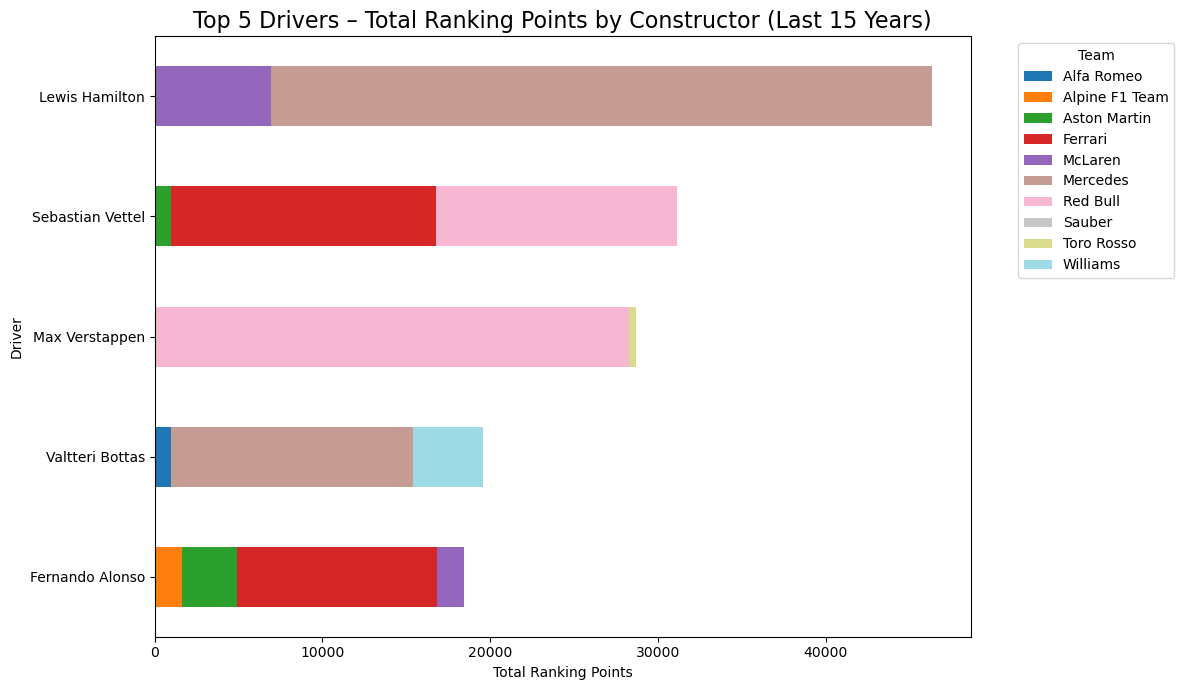

In [46]:
# ============================
# 5) Stacked Bar Plot
# ============================

plt.figure(figsize=(12, 7))

# pivot: rows → drivers, columns → teams
pivot.plot(
    kind='barh',
    stacked=True,
    figsize=(12, 7),
    colormap='tab20'
)

plt.title("Top 5 Drivers – Total Ranking Points by Constructor (Last 15 Years)", fontsize=16)
plt.xlabel("Total Ranking Points")
plt.ylabel("Driver")

plt.legend(title="Team", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Step 9 - Before running the model, we will start encoding in this section.
- name: Referring to the name of the race. Dropped does not have contribution to the model. 
- race_datetime: splitted into day/month/year we will use this in the model 
- team name :label encoding used it is an important element 
- team nationality : label encoding used it is an important element 
- driver forename, surname : dropped does not have direct meaning in the model 
- driver_dob : we will calculate the age of the driver
- driver_nationality : label encode different countries may contribute to the model 
- statusId : shows the car's status in the dataset whether the car is disqualified, engine broke, finished etc. Label encoding is used 


In [47]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Keeping the original data and copying from itself
model_df = master_df_15y.copy()

# Splitting the time from race
model_df['race_year'] = model_df['race_datetime'].dt.year
model_df['race_month'] = model_df['race_datetime'].dt.month

# Calculating driver age
model_df['driver_age'] = (model_df['race_datetime'] - model_df['driver_dob']).dt.days / 365

# Categorical columns that need label encoding
cat_cols = ['team_name', 'team_nationality', 'driver_nationality', 'statusId']

encoders = {}   #to keep all the encoders

for col in cat_cols:
    le = LabelEncoder()                # new encoder for every column
    model_df[col] = le.fit_transform(model_df[col].astype(str))
    encoders[col] = le                 # for inverse transform if needed

# Dropping the cols that is not used in the model
model_df = model_df.drop(columns=[
    'name',               # race name
    'race_datetime',      # seperated to month/year
    'driver_forename',
    'driver_surname',
    'driver_dob'          # calculated age
])

# Check the model
print(model_df.info())

# Check if there is anything missing 
print("\nMissing values:\n", model_df.isna().sum().sort_values(ascending=False).head(10))


<class 'pandas.core.frame.DataFrame'>
Index: 6196 entries, 715 to 25159
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   resultId                      6196 non-null   int64  
 1   raceId                        6196 non-null   int64  
 2   driverId                      6196 non-null   int64  
 3   constructorId                 6196 non-null   int64  
 4   grid                          6196 non-null   int64  
 5   positionOrder                 6196 non-null   int64  
 6   points                        6196 non-null   float64
 7   statusId                      6196 non-null   int64  
 8   year                          6196 non-null   int64  
 9   team_name                     6196 non-null   int64  
 10  team_nationality              6196 non-null   int64  
 11  driver_nationality            6196 non-null   int64  
 12  driver_ranking_points         6196 non-null   float64
 13  drive

After encoding, we created another year column derived from racedatetime. Year and race_year, will check they are the same or not. If yes, will drop one of them to avoid duplications. 

In [48]:
#checking the year and race_year if they are the same 

(model_df['year'] == model_df['race_year']).value_counts()

True    6196
Name: count, dtype: int64

In [49]:
#dropping year because it will create duplication - keeping race_year because it is more suitable
#and related with race_month

model_df = model_df.drop(columns=['year'])

model_df.head()

,resultId,raceId,driverId,constructorId,grid,positionOrder,points,statusId,team_name,team_nationality,...,driver_ranking_points,driver_ranking_position,driver_ranking_wins,qualifying_position,constructor_ranking_points,constructor_ranking_position,constructor_ranking_wins,race_year,race_month,driver_age
715,21642,877,20,9,24,3,15.0,0,17,1,...,255.0,1.0,5.0,3.0,422.0,1.0,7.0,2012,11,25.358904
719,21044,852,30,131,24,5,10.0,0,14,4,...,42.0,8.0,0.0,24.0,98.0,4.0,0.0,2011,8,42.676712
726,20448,342,4,6,24,6,8.0,0,5,6,...,75.0,3.0,1.0,24.0,136.0,2.0,1.0,2010,5,28.816438
754,20666,351,13,6,24,8,4.0,0,5,6,...,128.0,6.0,0.0,24.0,319.0,3.0,4.0,2010,9,29.441096
755,20880,845,2,4,24,8,4.0,5,18,3,...,25.0,7.0,0.0,24.0,46.0,4.0,0.0,2011,5,34.054795


In [50]:
#sanity check one last time before running the models and resetting index

model_df = model_df.reset_index(drop=True)

# total rows
total_rows = model_df.shape[0]

# Duplicate rows (resultId, raceId, driverId, constructorId control)
duplicates = model_df.duplicated(subset=['resultId','raceId','driverId','constructorId'], keep=False).sum()

# Missing values
missing_values = model_df.isna().sum().sum()

# Table
summary = pd.DataFrame({
    'Total Rows': [total_rows],
    'Duplicate Rows': [duplicates],
    'Missing Values': [missing_values]
})

print(summary)

   Total Rows  Duplicate Rows  Missing Values
0        6196               0               0


Step 10 - checking the correlations just to get an idea. Our target variable will be points. Points in here is represented as the overall points earned per race. We will try to predict the features that are impacting points. 

In [51]:
#checking the correlations before running the model 

corr_matrix = model_df.corr()  # Correlation of all numerical values

# Getting the correlations against target variable 'points'
points_corr = corr_matrix['points'].drop('points')  

# Sort corr values in descending format
print(points_corr.sort_values(ascending=False))

# If|correlation|>0.8-0.9 that means the values are highly correlated with points
threshold = 0.8
high_corr_features = points_corr[points_corr.abs() > threshold].index.tolist()

print("Highly correlated values with points:", high_corr_features)


driver_ranking_points           0.638441
constructor_ranking_points      0.599620
driver_ranking_wins             0.543688
constructor_ranking_wins        0.539107
driver_age                      0.118932
race_year                       0.041761
resultId                        0.038963
raceId                          0.036597
team_name                       0.008983
race_month                      0.005767
driver_nationality             -0.127457
constructorId                  -0.134003
team_nationality               -0.170027
driverId                       -0.229316
statusId                       -0.362131
grid                           -0.621812
qualifying_position            -0.656830
constructor_ranking_position   -0.667818
driver_ranking_position        -0.695175
positionOrder                  -0.827460
Name: points, dtype: float64
Highly correlated values with points: ['positionOrder']


Step 11 - As mentioned in step 10, our target variable will be points. We will try to identify what features are impacting the points. There are values that need to be dropped before running models. If we keep them, these values will directly impact the model, causing target leakage. To prevent that, we will drop;
- positionorder: Represents the ranking that is obtained from the race. Directly explains points. If you win the race you get 10 points 
- driver_ranking&constructor_ranking positions: All the position info represents the same thing. If we know the driver who won the race or the constructor who got the highest score, we will know the points. Again direct impact to the model. 
- statusId : Directly impacting points because it shows whether the car is disqualified, engine is broken etc. If a car is disqualified, the driver will get 0 points. 
- qualifying_position&grid: Also impacted the model because they have indirect effect on the points.


In [52]:
# Getting the copy of the original model_df
model_df2 = model_df.copy()

# defining the columns that directly impact the target variable
high_corr_features = [
    'positionOrder',
    'driver_ranking_position',
    'constructor_ranking_position',
    'statusId',
    'qualifying_position',
    'grid'
]

# defining target variable and features and dropping Id columns and high correlated columns
y = model_df2['points']
X = model_df2.drop(columns=['points', 'resultId', 'raceId', 'driverId', 'constructorId'] + high_corr_features)


Step 12 - running a random forest model to see which features dominate the points earned in the race. 

Random Forest Test RMSE: 4.83
Random Forest TRAIN RMSE: 1.80
Random Forest Test R2: 0.54
Random Forest Train R2:  0.94


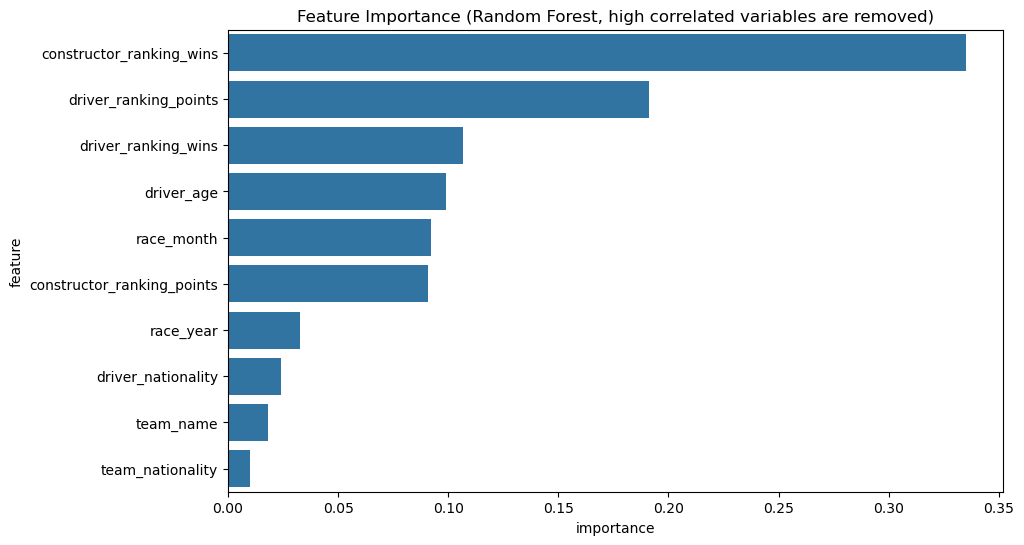

In [53]:
# Train/Test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Random Forest Model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score


rf = RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# RMSE calculation - test 
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print(f"Random Forest Test RMSE: {rmse_rf:.2f}")

# RMSE calculations - train
y_pred_rf_train = rf.predict(X_train)  # Train rmse 
rmse_rf_train = np.sqrt(mean_squared_error(y_train, y_pred_rf_train))
print(f"Random Forest TRAIN RMSE: {rmse_rf_train:.2f}")

#R2 Test result
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest Test R2: {r2_rf:.2f}")

# R2 Train result
r2_train = r2_score(y_train, y_pred_rf_train)
print(f"Random Forest Train R2:  {r2_train:.2f}")


# Feature importance
feat_imp = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=feat_imp)
plt.title("Feature Importance (Random Forest, high correlated variables are removed)")
plt.show()



Step 13 - random forest model is indicating a severe overfitting problem. We would like to try running the model by using XGBoost model, which we believe will give us better results. Boosting is more powerful than Random Forest, especially in complex relationships.
This F1 data:
- contains a lot of interactions
- has a lot of nonlinear patterns
- driver + team + year + positions, etc. all interact with each other
The Boosting model captures these much better than Random Forest. 

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'subsample': np.float64(0.6), 'reg_lambda': 2, 'reg_alpha': 0.5, 'n_estimators': np.int64(100), 'max_depth': np.int64(5), 'learning_rate': np.float64(0.042222222222222223), 'colsample_bytree': np.float64(0.7)}
Best Score (CV RMSE): 4.589561201893954
Test RMSE: 4.36
Train RMSE: 4.01
Train R2: 0.68
Test R2: 0.63


/var/folders/12/k8j1fhn921b554y1r1sl40qc0000gn/T/ipykernel_76039/313322299.py:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feat_imp, palette='crest')


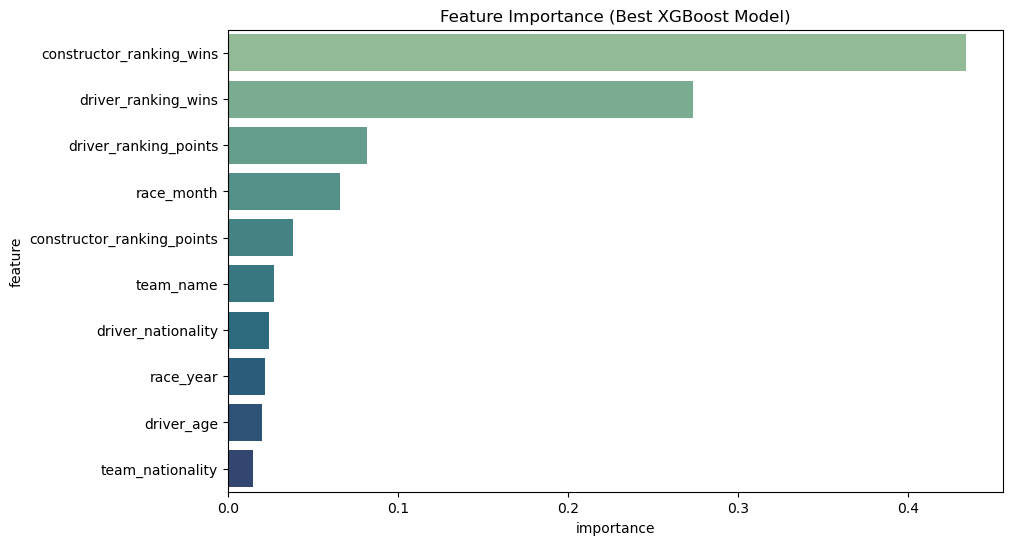

In [55]:
#Now calculating with XGBoost 

#Looking for ideal parameters by using RandomizedSearchCV 

from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score


# Defining Target and features
y = model_df2['points']
X = model_df2.drop(columns=['points', 'resultId', 'raceId', 'driverId', 'constructorId'] + high_corr_features)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# XGBoost model
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

# Parameter Intervals
param_distributions = {
    'n_estimators': np.arange(100, 1000, 100),
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'max_depth': np.arange(3, 8),
    'subsample': np.linspace(0.6, 1.0, 5),
    'colsample_bytree': np.linspace(0.6, 1.0, 5),
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0.5, 1, 2, 5]
}

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_distributions,
    n_iter=30,                # how many combinations to try
    scoring='neg_root_mean_squared_error',
    cv=3,                     # 3-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1                 # using all CPU 
)

# Fit
random_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", random_search.best_params_)
print("Best Score (CV RMSE):", -random_search.best_score_)

# Performance on test set 
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse_test:.2f}")

#calculating  train RMSE to check for overfitting 
new_train_rmse = np.sqrt(mean_squared_error(y_train, best_model.predict(X_train)))
print(f"Train RMSE: {new_train_rmse:.2f}")

# Train R2
r2_train = r2_score(y_train, best_model.predict(X_train))
print(f"Train R2: {r2_train:.2f}")

# Test R2
r2_test = r2_score(y_test, best_model.predict(X_test))
print(f"Test R2: {r2_test:.2f}")

#checking the feature importance based on the new XGBoost Model 

feat_imp = pd.DataFrame({
    'feature': X.columns,
    'importance': best_model.feature_importances_
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=feat_imp, palette='crest')
plt.title("Feature Importance (Best XGBoost Model)")
plt.show()


XGBoost Model gave us a better result compared to Random Forest. We used RandomizedSearchCV to get the ideal parameters for the model. 
Best Parameters:
- n_estimators = 100 (Small but enough for boosting) 
- max_depth = 5 (Ideal, prevents overfitting) 
- learning_rate = 0.042 (Looks stable, slow learning process, fitting without errors) 
- subsample = 0.6 (Protecting from overfitting)
- colsample_bytree = 0.7 (Feature subsampling, decreasing the risk of overfit)
- reg_alpha = 0.5 (L1 regularization)
- reg_lambda = 2 (L2 regularization)

In [56]:
#show the Feature importance values as table 
feat_imp = pd.DataFrame({
    'feature': X.columns,
    'importance': best_model.feature_importances_
}).sort_values(by='importance', ascending=False)

print(feat_imp)

                      feature  importance
6    constructor_ranking_wins    0.433877
4         driver_ranking_wins    0.273471
3       driver_ranking_points    0.081419
8                  race_month    0.065750
5  constructor_ranking_points    0.038096
0                   team_name    0.026984
2          driver_nationality    0.024025
7                   race_year    0.021736
9                  driver_age    0.020251
1            team_nationality    0.014392


In [57]:
#checking the baseline RMSE as a last step to see XGBoost performance

#checking the baseline RMSE to compare with model RMSE - looking good
baseline_rmse = np.sqrt(np.mean((y_test - y_test.mean())**2))
print(baseline_rmse)

7.145140799049479


Step 14 - plotting SHAP values to see the interactions of the variables in getting higher points in a race.

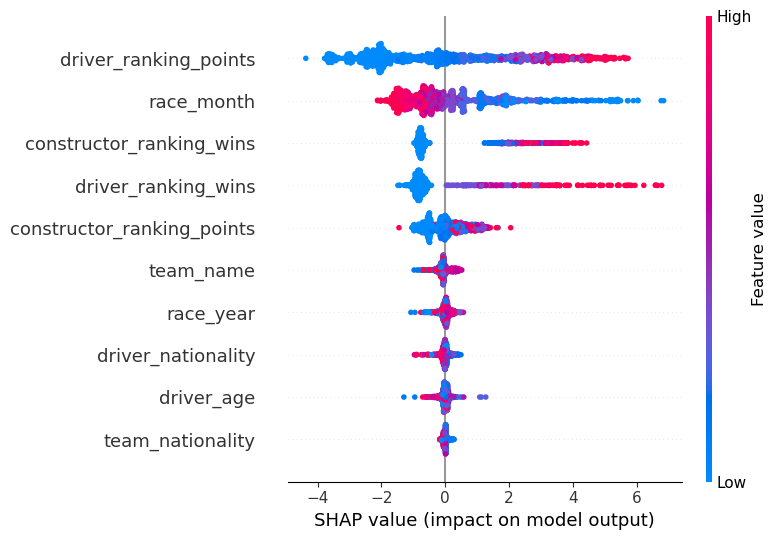

In [58]:
import shap

# SHAP explainer 
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)
plt.figure(figsize=(10,6))
shap.summary_plot(shap_values, X_test, plot_type="dot")



Based on the results: In Formula 1, general success (according to XGBoost Feature Importance) largely depends on the constructor performance and the team infrastructure. However, when examining individual race results (according to SHAP values), the driver's earned points in that particular race play a critical role in determining the specific number of points earned.

Step 15 - we have identified the global and local feature importance of the model. For global importance, constructor performance is playing a crucial role. Now we are moving on with the fairness analysis to see the model's prediction for the teams. 

=== FAIRNESS BY TEAM (sorted by bias_gap, descending) ===


,count,mean_true,mean_pred,mean_error,mae,bias_gap
team,,,,,,
Haas F1 Team,77,0.662338,1.165090,0.502753,1.231248,0.502753
Alfa Romeo,32,0.687500,0.995353,0.307853,0.929292,0.307853
Alpine F1 Team,25,2.960000,3.102887,0.142887,3.080667,0.142887
Virgin,19,0.000000,0.104220,0.104220,0.114192,0.104220
Sauber,69,1.043478,1.137841,0.094363,1.092655,0.094363
Manor Marussia,22,0.000000,0.076296,0.076296,0.100415,0.076296
Lotus,19,0.000000,0.064117,0.064117,0.074000,0.064117
Aston Martin,28,2.392857,2.446033,0.053176,2.559725,0.053176
HRT,32,0.000000,0.049615,0.049615,0.070900,0.049615


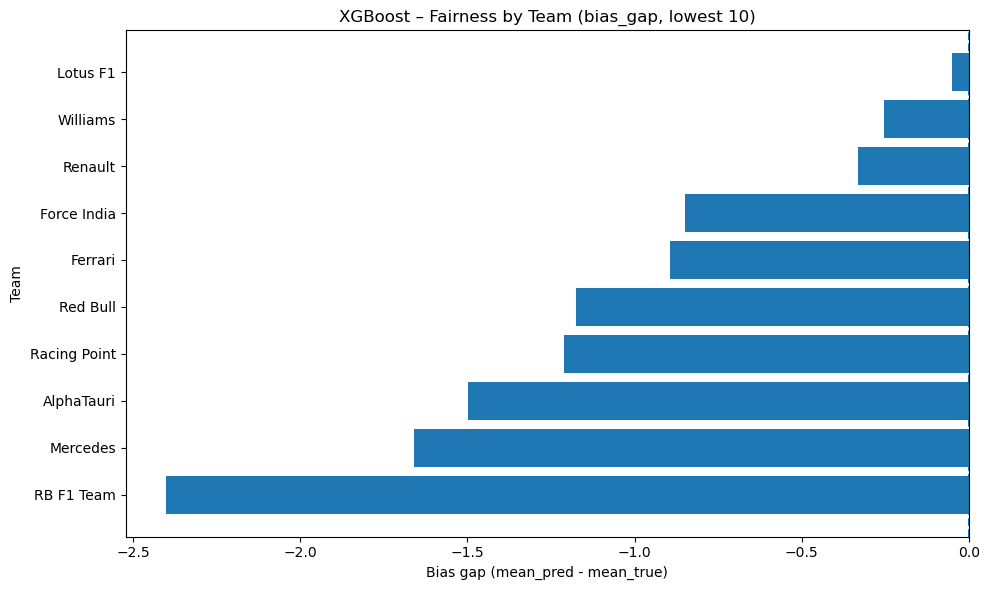

In [60]:
# XGBoost Fairness Analysis by Team (Constructor)

# 1) Test set predictions
y_pred_test = best_model.predict(X_test)

# 2) Creating Fairness dataframe
fairness_df = X_test.copy().reset_index(drop=True)
fairness_df['y_true'] = y_test.reset_index(drop=True)
fairness_df['y_pred'] = y_pred_test

# 3) Team name is encoded to use it in the model. We are reversing the encoded team_name that I kept in encoders in above encoding section.

fairness_df['team'] = encoders['team_name'].inverse_transform(
    fairness_df['team_name'].astype(int)
)

# 4) Calculating Error Metrics
fairness_df['error'] = fairness_df['y_pred'] - fairness_df['y_true']
fairness_df['abs_error'] = fairness_df['error'].abs()

# 5) Team based fairness table
fairness_table = (
    fairness_df
    .groupby('team')
    .agg(
        count      = ('y_true', 'size'),
        mean_true  = ('y_true', 'mean'),
        mean_pred  = ('y_pred', 'mean'),
        mean_error = ('error', 'mean'),
        mae        = ('abs_error', 'mean')
    )
    .assign(
        bias_gap = lambda df: df['mean_pred'] - df['mean_true']  # positive: over prediction, negative: under prediction
    )
    .sort_values('bias_gap', ascending=False)
)

print("=== FAIRNESS BY TEAM (sorted by bias_gap, descending) ===")
display(fairness_table)

# 6) Teams with most negative/pozitive bias gap (lowest is 10)
top_n = 10
plot_df = fairness_table.sort_values('bias_gap')  # from negative to positive

plt.figure(figsize=(10, 6))
plt.barh(plot_df.head(top_n).index, plot_df.head(top_n)['bias_gap'])
plt.axvline(0, linestyle='--')
plt.xlabel("Bias gap (mean_pred - mean_true)")
plt.ylabel("Team")
plt.title("XGBoost – Fairness by Team (bias_gap, lowest 10)")
plt.tight_layout()
plt.show()


To conclude, the fairness analysis shows that the XGBoost model does not distort the overall team hierarchy: the top teams remain at the top in terms of predicted points. However, in terms of calibration, the model tends to slightly under-predict the average points for leading teams such as Mercedes and Red Bull by around 1–2 points, while being mildly over-optimistic for back-marker teams like Haas and Alfa Romeo.